## Spotify Billboard 200 Linear Models

We take a break from the complex boosted tree models and see how nice, simple linear models would do. We apply logistic regression and a stochastic gradient descent-optimized linear support vector machine to both the resampled and reduced feature training data `Xm_train` and to the full featured training data `X_train`. We again taking advantage of previously pickled models and training and test data split out from the original full feature data. Please refer to `README.md` for descriptions of the data files, or read through `bb200_second_impression.ipynb` for details on boosted tree performance.

In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import GridSearchCV
# custom visualization function
from multiclass_stats import multiclass_stats
sns.set()
%matplotlib inline

### Initializing feature matrices

We read `X_train`, `y_train`, `X_test`, `y_test`, `Xm_train`, `ym_train`, `Xm_test`, `ym_test` feature and response data from .csv files on disk. Recall that the full feature data contains 26 columns, while the reduced and resampled feature data contains 9 columns.

In [2]:
X_train, y_train = pd.read_csv("./data/X_train.csv"), pd.read_csv("./data/y_train.csv")
X_test, y_test = pd.read_csv("./data/X_test.csv"), pd.read_csv("./data/y_test.csv")
Xm_train, ym_train = pd.read_csv("./data/Xm_train.csv"), pd.read_csv("./data/ym_train.csv")
Xm_test, ym_test = pd.read_csv("./data/Xm_test.csv"), pd.read_csv("./data/ym_test.csv")

### Logistic regression: `X_train`

We first run our logistic regression model on our full featured training data matrix to get a baseline estimation of performance without feature selection and resampling and to choose model hyperparameters. As usual, we perform 5-fold cross validation on our training data, and choose accuracy as our metric. We have a couple hyperparameters that we are interested in tuning, including the regularization strength and number of solver iterations.

**Remark.** Some hyperparameters we do not tune. For example, we use $ L^2 $-norm regularization only, as we do not want feature selection from $ L^1 $-norm or elastic net regularization. We will allow the optimizer to solve only the primal formulation of the optimization problem, as [model documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) recommends primal formulation when our number of features is less than the number of samples. We will also avoid intercept scaling, which is implemented only with the `liblinear` solver. Also, we will limit our solver to `lbfgs`, the limited memory implementation of the BFGS quasi-Newton method, as although the model documentation says that `sag` is faster, we have categorical variables which are technically of a different scale, and we know that gradient-based optimization methods are sensitive to feature scaling. We have only a binary classification problem at hand so we can ignore the `multi_class` parameter.

**Remark.** Using `n_jobs = 2`, this takes about 3 minutes to run on my machine. Of course, results may vary.

In [3]:
flr = LogisticRegression(solver = "lbfgs")
flr_grid = {"C": [1, 1e1, 1e2, 1e4], "max_iter": [100, 200, 400]}
# fit with accuracy as metric, run in parallel with 2 cores and 5-fold cv
flr_gscv = GridSearchCV(flr, flr_grid, scoring = "accuracy", n_jobs = 2, cv = 5, verbose = 1)
# hide the output of the grid search object
_ = flr_gscv.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.9min
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:  2.6min finished
c:\users\d\start\python3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


We then check our average cross-validated accuracy and then the test accuracy of our best predictor, and show that model.

In [135]:
# our best boosted tuned tree classifer
flr_best = flr_gscv.best_estimator_
print("5-fold CV flr grid accuracy:\t{0:.5f}\nbest flr grid accuracy:\t\t{1:.5f}\n"
      "best flr test accuracy:\t\t{2:.5f}"
      "".format(flr_gscv.cv_results_["mean_test_score"].mean(), flr_gscv.best_score_, 
                flr_best.score(X_test, y_test)))
# show the best logistic regression model for full features
flr_best

5-fold CV flr grid accuracy:	0.74899
best flr grid accuracy:		0.74900
best flr test accuracy:		0.75032


LogisticRegression(C=10000.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

As with the boosted tree models fit on the full feature training data set `X_train`, we do not see overfitting. The accuracy of the simpler logistic regression model is actually not too far away from the more complex boosted tree models, and is much faster to train to boot. Looking at the parameter `C`, which is the inverse of regularization strength, it appears that less regularization is favored by the model. As we know, accuracy is not the whole story, so we need to show other statistics like our confusion matrix, AUC, ROC curve, and misclassification rates, and then save our plot to the `./figures` directory.

misclassification rate for 0:	0.36708
misclassification rate for 1:	0.17258
best flr test precision:	0.77436
best flr test AUC:		0.73017


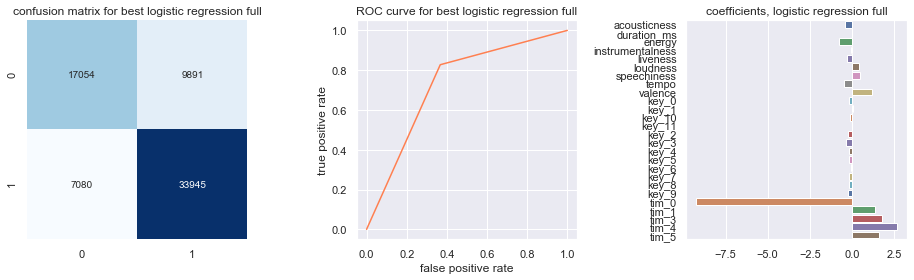

In [136]:
# create and save figure; return figure, confusion matrix, and statistics
fig, cmat, stats_dict = multiclass_stats(flr_best, X_test, y_test, best_model = True, 
                                         model_name = "logistic regression full", feature_ws = True,
                                         out_file = "./figures/flr_gscv_stats.png")
# misclassification rates
print("misclassification rate for 0:\t{0:.5f}\nmisclassification rate for 1:\t{1:.5f}"
      "".format(*stats_dict["mc_rates"]))
# predicted values from test feature matrix
print("best flr test precision:\t{0:.5f}\nbest flr test AUC:\t\t{1:.5f}" 
      "".format(stats_dict["precision"], stats_dict["auc"]))

The logistic regression model has a noticeably worse AUC and precision in comparison to the tree-based models run, and also experiences higher misclassification rates across the board, but is not terrible compared to the more fancy models we used. The coefficients tell a very interesting story, however. We know that under the logistic regression model, for an $ n \times m $ feature matrix $ \mathbf{X} $, where there are $ n $ observations and $ m $ features, with $ n \times 1 $ response vector $ \mathbf{y} $ s.t. $ \forall y_i \in \mathbf{y} $, $ y_i \in \{0, \, 1\} $, with probability of observation $ i $ being in class 1 defined as $ p_i \triangleq \mathbb{P}(y_i = 1 \mid \mathbf{x}_i) $, the estimated log-odds are given by

$$ \mathcal{L}(\hat{p}_i) = \log\left(\frac{\hat{p}_i}{1 - \hat{p}_i}\right) = \hat{\beta}_0 + \sum_{k = 1}^m\hat{\beta}_kx_i^{(k)} $$

Here $ \mathbf{x}_i = [ \ x_i^{(1)} \, \ldots \, x_i^{(m)} \ ] $ is a $ 1 \times m $ row vector observation in $ \mathbf{X} $. It is clear that $ \mathcal{L} : (0, \, 1) \rightarrow \mathbb{R} $ is monotonically increasing with $ \hat{p}_i \in (0, \, 1) $, and that

$$ \frac{\partial \mathcal{L}(\hat{p}_i)}{\partial x_i^{(k)}} = \hat{\beta}_k $$

So clearly log-odds are linear in the coefficients. Looking at our coefficients, it is interesting to see that the most important feature in determining if an observation is in class 0 is `tim_0`, which labels a song as having zero beats per measure, clearly a mistake and thus perhaps an example of spurious correlation. All the categorical variables indicating how many beats per measure a song has seem to vary positively with the log-odds, as does `valence` and `speechiness`. Interestingly, higher `energy` is associated with slightly higher log-odds of being in class 0, which is contrary to intuition. In general, the coefficients from our logistic regression model on the full `X_train` are confusing and counterintuitive. We now pickle our `GridSearchCV` object.

In [6]:
with open("./models/flr_gscv.pickle", "wb") as flr_gscv_file:
    pickle.dump(flr_gscv, flr_gscv_file)

### Logistic regression: `Xm_train`

We now apply logistic regression to our resampled, reduced feature training data `Xm_train`. A priori, we expect to experience overfitting such as with the tree-based models, but since logistic regression carries a parametric form, we expect that the degree of overfitting will be less. We perform the same 5-fold cross validated grid search, again varying the regularization parameter, maximum number of iterations, but also adding the option for `sag` as well as `lbfgs`, as the reduced feature matrix has only continuous variables that are all of zero sample mean, unit sample variance. Again accuracy is our metric.

**Remark.** Using `n_jobs = 2`, this takes a little over a minute to run on my machine.

In [12]:
# set a fixed initial random state for data shuffling when performing sag
lr = LogisticRegression(random_state = 9)
lr_grid = {"C": [1, 1e1, 1e2, 1e4], "max_iter": [100, 200, 400], "solver": ["lbfgs", "sag"]}
# fit with accuracy as metric, run in parallel with 2 cores and 5-fold cv
lr_gscv = GridSearchCV(lr, lr_grid, scoring = "accuracy", n_jobs = 2, cv = 5, verbose = 1)
# hide the output of the grid search object
_ = lr_gscv.fit(Xm_train, ym_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   28.8s
[Parallel(n_jobs=2)]: Done 120 out of 120 | elapsed:  1.3min finished
c:\users\d\start\python3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


As usual we check our average cross-validated accuracy and the test accuracy of our best predictor, and show that model.

In [13]:
# our best logistic regression classifer
lr_best = lr_gscv.best_estimator_
print("5-fold CV lr grid accuracy:\t{0:.5f}\nbest lr grid accuracy:\t\t{1:.5f}\n"
      "best lr test accuracy:\t\t{2:.5f}"
      "".format(lr_gscv.cv_results_["mean_test_score"].mean(), lr_gscv.best_score_, 
                lr_best.score(Xm_test, ym_test)))
# show the best logistic regression model for resampled + reduced features
lr_best

5-fold CV lr grid accuracy:	0.87669
best lr grid accuracy:		0.87670
best lr test accuracy:		0.72347


LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=9, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

As we saw before with the more complex models, there is significant overfitting, almost to the same degree as our more complex models. However, there is a marked drop in test accuracy from 75% to 72%, unlike with the more complex models, which experienced a less than 1% point drop in test accuracy on the resampled, reduced feature `Xm_train`. Let us examine some other metrics, as of course accuracy is not everything.

misclassification rate for 0:	0.19751
misclassification rate for 1:	0.32843
best lr test precision:		0.83810
best lr test AUC:		0.73703


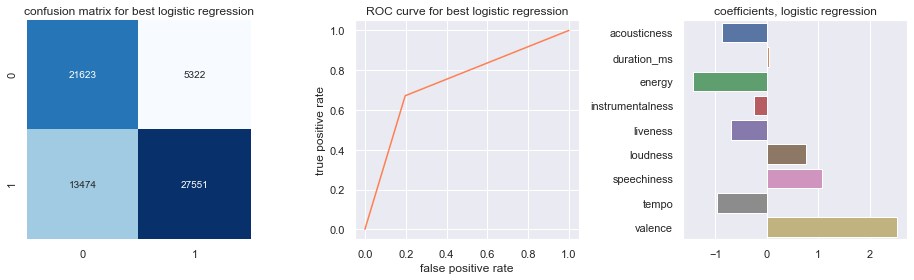

In [137]:
# create and save figure; return figure, confusion matrix, and statistics.
fig, cmat, stats_dict = multiclass_stats(lr_best, Xm_test, ym_test, best_model = True, 
                                         model_name = "logistic regression", feature_ws = True,
                                         out_file = "./figures/lr_gscv_stats.png")
# misclassification rates
print("misclassification rate for 0:\t{0:.5f}\nmisclassification rate for 1:\t{1:.5f}"
      "".format(*stats_dict["mc_rates"]))
# predicted values from test feature matrix
print("best lr test precision:\t\t{0:.5f}\nbest lr test AUC:\t\t{1:.5f}" 
      "".format(stats_dict["precision"], stats_dict["auc"]))

As with the more complex models, the precision of the model is significantly increased after resampling and feature elimination, but we see that for the logistic regression model, the misclassification rates for both classes are higher. But as before, we see how the misclassification rate for 0 has fallen while the misclassification rate for 1 has sharply risen, which is consistent with observations on tree models, except for the fact that the rise in the misclassification rate for 1 is much more marked then with the models. AUC, however, has not increased noticeably. But looking at the model coefficients, we see that qualitatively, the coefficients seem to have both the same sign and magnitude as the coefficients of the continuous features in the logistic regression model we fitted on the full-featured `X_train`! Intuitively, as before, we are confused, as higher `energy` is associated with greater log-odds of being in class 0. Some coefficients make more intuitive sense: for example, a "happier" song, with higher `valence`, should be more likely to be in class 1. Also, `duration_ms` does not seem to have much of an effect, while `tempo` varies inversely with log-odds of being in class 1. 

We now pickle our model for later, as is good practice.

In [14]:
with open("./models/lr_gscv.pickle", "wb") as lr_gscv_file:
    pickle.dump(lr_gscv, lr_gscv_file)

### Stochastic gradient descent: `X_train`

We now move on to using stochastic gradient descent to train a linear classifier, which gives a linear soft margin support vector machine. Gradient descent is sensitive to feature scaling, and since we have a mix of scales, i.e. our continuous features have zero mean and unit sample variance, while our categorical features are strictly within $ \{0, \, 1\} $, it is reasonable to expect that gradient descent will not converge too quickly on the full feature matrix. We are interested in tuning only our regularization coefficient alpha, as although we would also be interested in tuning the learning rate, the adaptive learning rate used by default is a function of alpha as well. We keep $ L^2 $ regularization since we do not want feature selection, and are happy with the other defaults.

As usual, we perform a 5-fold cross validated grid search, running in parallel with `n_jobs = 2`, and use accuracy as our metric.

**Remark.** You can read the documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) for the `SGDClassifier` class.

**Remark.** The grid search takes around less than a minute on my machine with `n_jobs = 2`. Of course, results vary.

In [146]:
# set fixed random seed for data shuffling
fsgd = SGDClassifier(random_state = 9, learning_rate = "optimal")
fsgd_grid = {"alpha": [1e-4, 1e-2, 1e-1, 1]}
# fit with accuracy as metric, run in parallel with 2 cores and 5-fold cv
fsgd_gscv = GridSearchCV(fsgd, fsgd_grid, scoring = "accuracy", n_jobs = 2, cv = 5, verbose = 1)
# hide the output of the grid search object
_ = fsgd_gscv.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   16.3s finished
c:\users\d\start\python3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


As usual, we check the cross-validated accuracy and the test accuracy of our best predictor, and show the model.

In [153]:
fsgd_best = fsgd_gscv.best_estimator_
print("5-fold CV fsgd grid accuracy:\t{0:.5f}\nbest fsgd grid accuracy:\t{1:.5f}\n"
      "best fsgd test accuracy:\t{2:.5f}"
      "".format(fsgd_gscv.cv_results_["mean_test_score"].mean(), fsgd_gscv.best_score_, 
                fsgd_best.score(X_test, y_test)))
# show the best stochastic gradient descent classifier on X_train
fsgd_best

5-fold CV fsgd grid accuracy:	0.71159
best fsgd grid accuracy:	0.74770
best fsgd test accuracy:	0.74892


SGDClassifier(alpha=0.01, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=9, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

Interestingly, we see that the average cross-validated training accuracy is surprisingly low, but the best fitted estimator has consisteny test and training accuracy, both of which are just below that of our basic logistic regression. Perhaps one additional plus lies in how quickly the model was trained on the full feature matrix. We now show our misclassification rates, precision, AUC, ROC curve, and check coefficients.

misclassification rate for 0:	0.36716
misclassification rate for 1:	0.17484
best fsgd test precision:	0.77385
best fsgd test AUC:		0.72900


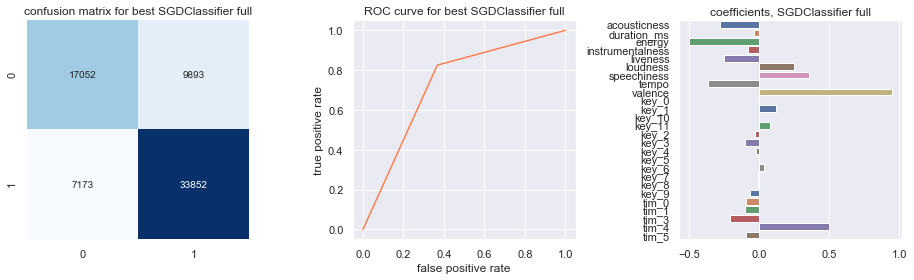

In [150]:
# create and save figure; return figure, confusion matrix, and statistics.
fig, cmat, stats_dict = multiclass_stats(fsgd_best, X_test, y_test, best_model = True, 
                                         model_name = "SGDClassifier full", feature_ws = True,
                                         out_file = "./figures/fsgd_gscv_stats.png")
# misclassification rates
print("misclassification rate for 0:\t{0:.5f}\nmisclassification rate for 1:\t{1:.5f}"
      "".format(*stats_dict["mc_rates"]))
# predicted values from test feature matrix
print("best fsgd test precision:\t{0:.5f}\nbest fsgd test AUC:\t\t{1:.5f}" 
      "".format(stats_dict["precision"], stats_dict["auc"]))

We see that compared to the standard logistic regression on `X_train`, misclassification rates, precision, and AUC are almost exactly the same, although maybe AUC is slightly lower. As is true for all the models trained on the full featured matrix, the misclassification rate for 0 is much higher than that of 1. The coefficients of the classifier themselves also tell an interesting story. Under the `sklearn` implementation of the linear stochastic gradient descent classifier, for $ n $ training examples $ (\mathbf{x}_i, \, y_i) $, where $ \mathbf{x}_i \in \mathbb{R}^m $, $ y_i \in \{-1, \, 1\} $, our estimated classifier $ \hat{G}(\mathbf{x}_i) $, with $ m \times 1 $ weight vector $ \mathbf{w} $, $ b \in \mathbb{R} $, is given by

$$ \hat{G}(\mathbf{x}_i) = \text{sgn}\hat{f}(\mathbf{x}_i) = \text{sgn}\left(\mathbf{w}^\text{T}\mathbf{x}_i + b\right) $$

The interpretation of the weight coefficients in $ \mathbf{w} $ is similar as the interpretation in logistic regression, as it is clear that

$$ \frac{\partial \hat{f}(\mathbf{x}_i)}{\partial x_i^{(k)}} = w_k $$

It is intuitively clear that the likelihood of $ \hat{G}(\mathbf{x}_i) = 1 $, *ceteris paribus*, increases monotonically with a single $ w_k \in \mathbf{w} $, as $ \hat{G}(\mathbf{x}_i) $ is just the sign of $ \hat{f}(\mathbf{x}_i) $. We see that the linear stochastic gradient descent classifier has some markedly different opinions with regards to which coefficients imply a higher likelihood of an observation falling in class 1. Although we see that almost all the continuous coefficients are the same sign and of similar relative scale to each other as with the logistic regression classifiers, save for `duration_ms`, which is now slightly negative, we do not see the huge dominance of the `tim_0` feature as we saw in the logistic regression model we trained on `X_train`. In general, the effects of the categorical variables are different from the logistic regression model, and we see instead that `tim_4` is considered the most important of the categorical variables in predicting whether or a not a song falls into class 1.

We now pickle our model for later, as is good practice, to save these interesting results, and now train on `Xm_train`.

In [151]:
with open("./models/fsgd_gscv.pickle", "wb") as fsgd_gscv_file:
    pickle.dump(fsgd_gscv, fsgd_gscv_file)

**Remark.** *Intuition on weight updates.* We use the hinge loss $ L(y_i, \, \hat{f}(\mathbf{x}_i)) = \max\{0, \, 1 - y_i\hat{f}(\mathbf{x}_i)\} $. $ \alpha $ scales our regularization term $ \frac{1}{2}\mathbf{w}^\text{T}\mathbf{w} $, as we chose $ L^2 $ regularization, with learning rate $ \eta_t \triangleq 1 / \alpha(t_0 + t) $, where $ t $ is time step (there are `n_samples` times `n_iters` time steps). Therefore, for each training example input $ (\mathbf{x}_i, \, y_i) $ encountered, our update to $ \mathbf{w} $, assuming we have not reached any stopping criteria, is given by

$$ \mathbf{w} \leftarrow \mathbf{w} -\eta_t\left\{\alpha\mathbf{w} + \begin{bmatrix} -x_i^{(1)}\mathbf{1}_{\{y_i\hat{f}(x_i) < 1\}} \\ \vdots \\ -x_i^{(m)}\mathbf{1}_{\{y\hat{f}(\mathbf{x}_i) < 1\}} \end{bmatrix} \ \right\} = (1 - \eta_t\alpha)\mathbf{w} + \eta_t\mathbf{x}_i\mathbf{1}_{\{y_i\hat{f}(\mathbf{x}_i) < 1\}} $$

Essentially, at every time step, we see that $ \mathbf{w} $ is shrunk slightly by a factor of $ 1 - \eta_t\alpha $, with individual weights updated by the direction of the observation $ \mathbf{x}_i $, scaled by $ \eta_t $. In other words, as long as $ |y_i\hat{f}(\mathbf{x}_i)| < 1 $, we adjust $ \mathbf{w} $ to bring $ \hat{f}(\mathbf{x}_i) $ closer to $ y_i $.

### Stochastic gradient descent: `Xm_train`

We now proceed to training the linear stochastic gradient descent model on `Xm_train`, looking to see if the differences in performance that arise from training on the resampled, reduced feature data that seem to hold for the other models also hold for the linear stochastic gradient descent classifier. As in the previous section, we want to tune only the regularization scaling coefficient alpha, as the learning rate $ \eta_t $ is a function of $ \alpha $ as well. As we always do, we keep our $ L^2 $ regularization, and proceed to do a 5-fold cross validated grid search with `n_jobs = 2`.

**Remark.** Stochastic gradient is fast; with `n_jobs = 2` the cell finishes in around 15 seconds on my machine.

In [154]:
# set fixed random seed for data shuffling
sgd = SGDClassifier(random_state = 9, learning_rate = "optimal")
sgd_grid = {"alpha": [1e-4, 1e-2, 1e-1, 1]}
# fit with accuracy as metric, run in parallel with 2 cores and 5-fold cv
sgd_gscv = GridSearchCV(sgd, sgd_grid, scoring = "accuracy", n_jobs = 2, cv = 5, verbose = 1)
# hide the output of the grid search object
_ = sgd_gscv.fit(Xm_train, ym_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   11.0s finished
c:\users\d\start\python3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


As usual, we check the cross-validated accuracy and the test accuracy of our best predictor, and show the model.

In [156]:
sgd_best = sgd_gscv.best_estimator_
print("5-fold CV sgd grid accuracy:\t{0:.5f}\nbest sgd grid accuracy:\t\t{1:.5f}\n"
      "best sgd test accuracy:\t\t{2:.5f}"
      "".format(sgd_gscv.cv_results_["mean_test_score"].mean(), sgd_gscv.best_score_, 
                sgd_best.score(Xm_test, ym_test)))
# show the best linear stochastic gradient descent classifier on Xm_train
sgd_best

5-fold CV sgd grid accuracy:	0.86941
best sgd grid accuracy:		0.87617
best sgd test accuracy:		0.72086


SGDClassifier(alpha=0.01, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=9, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

The performance of the linear stochastic gradient descent classifier trained on `Xm_train` reflects what we saw with the logistic regression model trained on `Xm_train`. Like with the more complex models, there is significant overfitting, to the same degree as the logistic regression model. The accompanying drop in test accuracy is also present, which is again unlike the more complex models. Of course, we need to examine other metrics.

misclassification rate for 0:	0.19425
misclassification rate for 1:	0.33489
best sgd test precision:	0.83905
best sgd test AUC:		0.73543


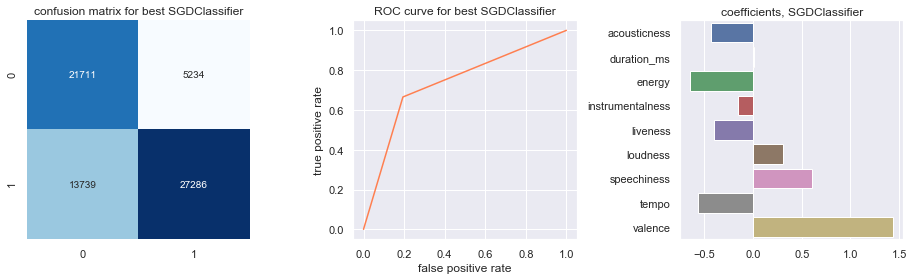

In [157]:
# create and save figure; return figure, confusion matrix, and statistics.
fig, cmat, stats_dict = multiclass_stats(sgd_best, Xm_test, ym_test, best_model = True, 
                                         model_name = "SGDClassifier", feature_ws = True,
                                         out_file = "./figures/sgd_gscv_stats.png")
# misclassification rates
print("misclassification rate for 0:\t{0:.5f}\nmisclassification rate for 1:\t{1:.5f}"
      "".format(*stats_dict["mc_rates"]))
# predicted values from test feature matrix
print("best sgd test precision:\t{0:.5f}\nbest sgd test AUC:\t\t{1:.5f}" 
      "".format(stats_dict["precision"], stats_dict["auc"]))

Again, as with all the models, we see a marked increase in precision, and a decrease in the misclassification rate of class 0, but at the cost of class 1 being misclassed much more severely, as we saw with the logistic regression model. The performance of the linear stochastic gradient descent classifier on `Xm_train` is similar to that of the logistic regression model, so there isn't too much new to add here. However, we can verify that as with the more complex models, there is a change in misclassification rates, significant increase in precision, and some increase in AUC as well. And looking at the coefficients, we see that they seem to be more or less of the same sign and relative scale as we saw when we trained the model on `X_train`.

We conclude our discussion of linear models here, as we have not really brought about any significantly new developments, really only verifying what we saw with the more complex models when we trained on the resampled, reduced feature matrix. We pickle this model for posterity.

In [158]:
with open("./models/sgd_gscv.pickle", "wb") as sgd_gscv_file:
    pickle.dump(sgd_gscv, sgd_gscv_file)

### Key takeaways

We trained linear classifiers on both the full preprocessed feature matrix `X_train` and the resampled, reduced feature matrix `Xm_train`, finding that on `X_train`, the simpler models performed worse than the more complex models did but not too much worse. When training the models on `Xm_train`, we verified our observation that models trained on `Xm_train` are severely overfit and do not exhibit an increase in test accuracy; for the simpler linear models, they actually lost about 3% in test accuracy after being trained on `Xm_train`. However, as was consistent with the more complex models, we do see that precision is significantly increased, and misclassification rates are balanced, although the misclassification rate of 1 for the linear models trained on `Xm_train` increased much more than for the more complex tree models. AUC also improved mildly.

Perhaps one of the more interesting things is seeing the coefficients of the models; the logistic regression and linear stochastic gradient descent classifier agreed on some features but heavily disagreed on others, namely the categorical features. It appears that the logistic regression model's obsession with the `tim_0` feature may be a spurious correlation, as observations with a 1 in that column are few (only around 630 or so), and there is no intuitive reasoning for this observation, as songs cannot have zero beats per measure. One could speculate that this is due to the type of song mislabeled this way.

Next steps are to proceed with intensive feature engineering, perhaps capturing some polynomial or multiplicative cross-effects between continuous features that could be useful. The categorical features seem to have limited predictive power, although their presence does prevent overfitting.